### Suggestions from Tutor
* Perhaps with SPY or other indices
* perform an hourly training/5 min traning, etc. 
* store pre-trained model 
* current data for prediction
* load model
* get ticker name input
* predict usining model
* show results

### Initial ML Attempt using LSTM RNN


**LSTM provides better predictions for the direction of price moves on negative news sentiments compared to positive sentiments**



### Resources:


_**Binary Keras LSTM model does not output binary predictions**_

"There is no 'binary' in neural networks, but a continuous function within limits.
Only with continuous functions a model can train and learn using "stochastic gradient descent".
For trying to achieve binary results, we use the sigmoid function, which goes from 0 to 1. But initially, your model is not trained, all its "weights" are sort of initialised randomly. 
The result is indeed results tending to mean values, which are 0.5 in sigmoid functions.
All you need is to train your model with enough data for enough epochs, 
so the results will gradually approach (but never hit) 0 or 1 (or whatever targets "y" you have in your training data)"

Source: https://stackoverflow.com/questions/46040656/binary-keras-lstm-model-does-not-output-binary-predictions

In [372]:
#Source: https://github.com/Derrick-Sherrill/DerrickSherrill.com/blob/master/stocks.py

import os
import pandas as pd

# importing libraries
from pathlib import Path
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data


from alpha_vantage.timeseries import TimeSeries
import time
from path import Path
%matplotlib inline
from datetime import datetime as dt
from dateutil.tz import gettz
import re
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import keras
from newsapi import NewsApiClient

#!pip install alpha_vantage
# get API from alpha vantage
api_key_stocks = os.getenv("ALPHA_VANTAGE_API_KEY")

#import nltk
#nltk.download()
from nltk.corpus import reuters
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read your api key environment variable
api_key_news = os.getenv("NEWS_API_KEY")
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key_news)


# News Data

In [373]:
#TODO: To be replaced by dropdown widgets from maui_stock_data.ipynb
tickers = ['SPY','DJIA','AAPL', 'GOOG', 'FB', 'NFLX','DIS', 'MSFT', 'IBM']
ticker = input ("Enter ticker :") 

Enter ticker : DIS


In [562]:
#df = pd.read_pickle('../Data/DIS_clean.pickle') # data as of 4/16/2020

In [618]:
df = pd.read_pickle('../Data/dis_ln_dum.pickle') # data as of 4/14/2020

In [619]:
df.head()

,compound,positive,negative,neutral,close,lagged_return_1d,lagged_return_3d,lagged_return_5d,return,Increase
date,,,,,,,,,,
2020-03-16,0.9832,0.075,0.034,0.890,95.01,0.0,0.0000,0.0,0.000000,1
2020-03-17,0.9963,0.107,0.040,0.853,93.53,0.0,0.0000,0.0,-0.015700,0
2020-03-18,0.9715,0.109,0.083,0.808,88.80,0.0,0.0000,0.0,-0.051896,0
2020-03-19,-0.8074,0.069,0.070,0.861,94.93,0.0,0.0000,0.0,0.066753,1
2020-03-20,0.8507,0.045,0.036,0.919,85.98,0.0,-0.0157,0.0,-0.099025,0


In [620]:
# Needed if using dis_dum where column Increase is in 0 or 1
#increase = df.Increase

In [621]:
# Transform Predicted column
#def changeIncrease(increase):
#    if increase == 1:
#        return 1.0
#    else:
#        return -1.0

#df["Increase"] = df["Increase"].apply(changeIncrease)
#df

In [622]:
dis = df.copy()

### Model
_**LSTM**_

In [623]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    
    for i in range(len(df) - window - 1):
        
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
               
        X.append(features)
        y.append(target)
     
        
    return np.array(X), np.array(y).reshape(-1, 1)

In [624]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
# A window_size of 1 means no lag in the timeframe defined later

window_size = 1 # 1day
#window_size = 2
#window_size = 3
#window_size = 4
#window_size = 5
#window_size = 6
#window_size = 7
#window_size = 8
#window_size = 9
#window_size = 10

_**Column index 1 is the `Positive` column**_

In [625]:
feature_column_pos = 1
target_column = 9    # Increase is the binary target column # this is 5 if using DIS_clean.pickle
X, y = window_data(dis, window_size, feature_column_pos, target_column)

In [626]:
# Apply One-hot encoding to the target labels
enc = OneHotEncoder()
enc.fit(y)
y = enc.transform(y).toarray()[:,0]
y = np.array(y).reshape(-1,1)

In [627]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [628]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [629]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.375]]] 

X_test sample values:
[[[0.6875]]]


In [630]:
print (f"y_train sample values:\n{y_train[:1]} \n")
print (f"y_test sample values:\n{y_test[:1]}")

y_train sample values:
[[1.]] 

y_test sample values:
[[0.]]


#### _**Build and Train the LSTM RNN**_

In [631]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [632]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Define the LSTM RNN model.

model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, activation='sigmoid', return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [633]:
X_train.shape

(11, 1, 1)

In [634]:
y_train.shape

(11, 1)

In [635]:
#y_train.reshape(-1,1)

In [636]:
X_test.shape

(6, 1, 1)

In [637]:
y_test.shape

(6, 1)

In [638]:
y_test.shape

(6, 1)

In [639]:
# Compile the model
model.compile(optimizer="adam", 
              metrics=["accuracy", "mse"],
              loss="mean_squared_error") 

In [640]:
# Summarize the model
model.summary() 

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 1, 20)             1760      
_________________________________________________________________
dropout_69 (Dropout)         (None, 1, 20)             0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 1, 20)             3280      
_________________________________________________________________
dropout_70 (Dropout)         (None, 1, 20)             0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_71 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [641]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [642]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

training_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=200,
    shuffle=False, 
    batch_size=1, 
    verbose=1) 

Train on 7 samples, validate on 4 samples
Epoch 1/200
7/7 [==============================] - 3s 491ms/sample - loss: 0.4761 - accuracy: 0.4286 - mse: 0.4761 - val_loss: 0.3790 - val_accuracy: 0.5000 - val_mse: 0.3790
Epoch 2/200
7/7 [==============================] - 0s 4ms/sample - loss: 0.4437 - accuracy: 0.4286 - mse: 0.4437 - val_loss: 0.3429 - val_accuracy: 0.5000 - val_mse: 0.3429
Epoch 3/200
7/7 [==============================] - 0s 5ms/sample - loss: 0.3886 - accuracy: 0.4286 - mse: 0.3886 - val_loss: 0.3154 - val_accuracy: 0.5000 - val_mse: 0.3154
Epoch 4/200
7/7 [==============================] - 0s 5ms/sample - loss: 0.3512 - accuracy: 0.4286 - mse: 0.3512 - val_loss: 0.2939 - val_accuracy: 0.5000 - val_mse: 0.2939
Epoch 5/200
7/7 [==============================] - 0s 5ms/sample - loss: 0.3481 - accuracy: 0.4286 - mse: 0.3481 - val_loss: 0.2778 - val_accuracy: 0.5000 - val_mse: 0.2778
Epoch 6/200
7/7 [==============================] - 0s 6ms/sample - loss: 0.2825 - accuracy:

In [643]:
# Evaluate the model on the test data using `evaluate`
print(f'\n Evaluate on test data for 5-minute rolling positive prices sentiments:')
model_loss, model_accuracy, model_mse = model.evaluate(X_test, y_test, verbose=0)
print(f'\n For unshuffled valuation, test loss on LSTM RNN is Loss: {model_loss:,.4f}, Accuracy: {model_accuracy:,.4f}.')



 Evaluate on test data for 5-minute rolling positive prices sentiments:

 For unshuffled valuation, test loss on LSTM RNN is Loss: 0.2589, Accuracy: 0.5000.


In [644]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [645]:
# Recover the original prices instead of the scaled version
real = y_test

In [646]:
# Create a DataFrame of Real and Predicted values
positive_sentiments = pd.DataFrame({
    "Real": real.ravel(),
    "Predicted": predicted.ravel()
})
positive_sentiments

,Real,Predicted
0,0.0,0.503331
1,1.0,0.420829
2,0.0,0.430724
3,0.0,0.414383
4,1.0,0.637515
5,0.0,0.689863


In [647]:
# Transform Predicted column
def changePredicted(predicted):
    if predicted >= 0.5:
        return 1.0
    else:
        return 0.0

positive_sentiments["Predicted"] = positive_sentiments["Predicted"].apply(changePredicted)
positive_sentiments

,Real,Predicted
0,0.0,1.0
1,1.0,0.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
5,0.0,1.0


<Figure size 432x288 with 0 Axes>

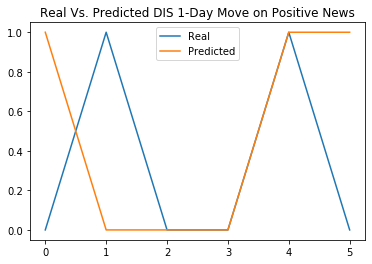

In [648]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
positive_sentiments.plot(title=f"Real Vs. Predicted {ticker} {window_size}-Day Move on Positive News")
plt.savefig(f'../Images/{ticker}_positive_lstm.png')
plt.show()

<Figure size 432x288 with 0 Axes>

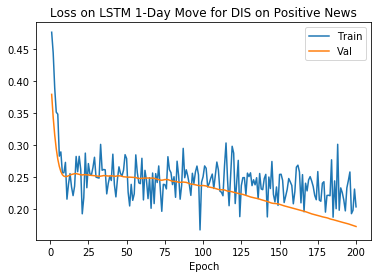

In [649]:
# Plotting loss
epochs = 200
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs+1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

plt.figure()
loss_df.plot(title=f"Loss on LSTM {window_size}-Day Move for {ticker} on Positive News")
plt.savefig(f'../Images/{ticker}_loss_positive_sentiments_lstm.png')
plt.show()

In [650]:
import h5py

model.save(f'../Models/{ticker}_lstm_loss_positive.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [651]:
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
# returns a compiled model
# identical to the previous one
#model = tf.keras.models.load_model(f'../Models/{ticker}_lstm_loss_positive.h5')

_**Column index 2 is the `Negative` column**_

In [652]:
feature_column_neg = 2
target_column = 9   # this is 5 if using DIS_clean on pct_change() for price moves
X, y = window_data(dis, window_size, feature_column_neg, target_column)

In [653]:
# Apply One-hot encoding to the target labels
enc = OneHotEncoder()
enc.fit(y)
y = enc.transform(y).toarray()[:,0]
y = np.array(y).reshape(-1,1)

In [654]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [655]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [656]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.23880597]]] 

X_test sample values:
[[[0.41791045]]]


In [657]:
print (f"y_train sample values:\n{y_train[:1]} \n")
print (f"y_test sample values:\n{y_test[:1]}")

y_train sample values:
[[1.]] 

y_test sample values:
[[0.]]


#### _**Build and Train the LSTM RNN**_

In [658]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [659]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Define the LSTM RNN model.

model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, activation='sigmoid', return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [660]:
# Compile the model
model.compile(optimizer="adam", 
              metrics=["accuracy", "mse"],
              loss="mean_squared_error") 

In [661]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [662]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

training_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=200,
    shuffle=False, 
    batch_size=1, 
    verbose=1) 

Train on 7 samples, validate on 4 samples
Epoch 1/200
7/7 [==============================] - 3s 411ms/sample - loss: 0.5864 - accuracy: 0.4286 - mse: 0.5864 - val_loss: 0.4748 - val_accuracy: 0.5000 - val_mse: 0.4748
Epoch 2/200
7/7 [==============================] - 0s 5ms/sample - loss: 0.5511 - accuracy: 0.4286 - mse: 0.5511 - val_loss: 0.4317 - val_accuracy: 0.5000 - val_mse: 0.4317
Epoch 3/200
7/7 [==============================] - 0s 6ms/sample - loss: 0.4842 - accuracy: 0.4286 - mse: 0.4842 - val_loss: 0.3942 - val_accuracy: 0.5000 - val_mse: 0.3942
Epoch 4/200
7/7 [==============================] - 0s 6ms/sample - loss: 0.4235 - accuracy: 0.4286 - mse: 0.4235 - val_loss: 0.3619 - val_accuracy: 0.5000 - val_mse: 0.3619
Epoch 5/200
7/7 [==============================] - 0s 6ms/sample - loss: 0.4021 - accuracy: 0.4286 - mse: 0.4021 - val_loss: 0.3347 - val_accuracy: 0.5000 - val_mse: 0.3347
Epoch 6/200
7/7 [==============================] - 0s 5ms/sample - loss: 0.3722 - accuracy:

In [663]:
# Evaluate the model on the test data using `evaluate`
print(f'\n Evaluate on test data for 5-minute rolling positive prices sentiments:')
model_loss, model_accuracy, model_mse = model.evaluate(X_test, y_test, verbose=0)
print(f'\n For unshuffled valuation, test loss on LSTM RNN is Loss: {model_loss:,.4f}, Accuracy: {model_accuracy:,.4f}.')



 Evaluate on test data for 5-minute rolling positive prices sentiments:

 For unshuffled valuation, test loss on LSTM RNN is Loss: 0.2801, Accuracy: 0.3333.


In [664]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [665]:
# Recover the original prices instead of the scaled version
real = y_test

In [666]:
# Create a DataFrame of Real and Predicted values
negative_sentiments = pd.DataFrame({
    "Real": real.ravel(),
    "Predicted": predicted.ravel()
})
negative_sentiments

,Real,Predicted
0,0.0,0.570788
1,1.0,0.568019
2,0.0,0.570447
3,0.0,0.570447
4,1.0,0.574452
5,0.0,0.579739


In [667]:
# Transform Predicted column
def changePredicted(predicted):
    if predicted >= 0.5:
        return 1.0
    else:
        return -0.0

negative_sentiments["Predicted"] = negative_sentiments["Predicted"].apply(changePredicted)
negative_sentiments

,Real,Predicted
0,0.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0
5,0.0,1.0


<Figure size 432x288 with 0 Axes>

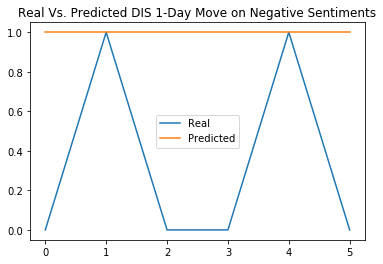

In [668]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
negative_sentiments.plot(title=f"Real Vs. Predicted {ticker} {window_size}-Day Move on Negative Sentiments")
plt.savefig(f'../Images/{ticker}_negative_lstm_predicted.png')
plt.show()

<Figure size 432x288 with 0 Axes>

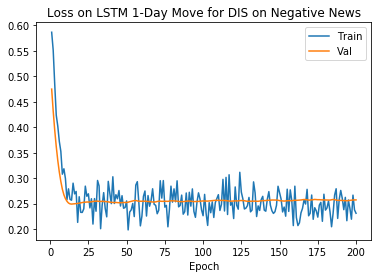

In [669]:
# Plotting loss
epochs = 200
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

plt.figure()
loss_df.plot(title=f"Loss on LSTM {window_size}-Day Move for {ticker} on Negative News")
plt.savefig(f'../Images/{ticker}_loss_lstm_negative_sentiments.png')
plt.show()

In [670]:
import h5py

model.save(f'../Models/{ticker}_lstm_loss_negative.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [671]:
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
# returns a compiled model
# identical to the previous one
model = tf.keras.models.load_model(f'../Models/{ticker}_lstm_loss_negative.h5')